In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

load_dotenv()

True

In [2]:
db_name = os.getenv("db_name")
db_user = os.getenv("db_user")
db_password = os.getenv("db_password")
db_host = os.getenv("db_host")

engine = create_engine(f'postgresql+psycopg2://{db_user}:{db_password}@{db_host}/{db_name}')

query = "SELECT * FROM StockPrice;"

df = pd.read_sql(query, engine)

In [3]:
df = df.set_index("date", drop=True)
df.head()

,ticker,open,high,low,close,volume,dividends,splits
date,,,,,,,,
2019-07-12,NOVN.SW,69.13,69.13,67.42,67.42,14439736,0.0,0.0
2019-07-15,NOVN.SW,67.33,68.12,67.03,67.91,6911171,0.0,0.0
2019-07-16,NOVN.SW,67.93,68.31,67.80,68.11,5953075,0.0,0.0
2019-07-17,NOVN.SW,68.16,69.74,68.09,69.38,7912449,0.0,0.0
2019-07-18,NOVN.SW,70.21,73.04,69.94,71.53,12043188,0.0,0.0


In [4]:
df_ts = df.pivot_table(values='close', index=df.index, columns='ticker')[:-1]
df_ts = df_ts.ffill()
df_ts

ticker,AAPL,AMZN,NOVN.SW,NVS,PFE
date,,,,,
2019-07-12,49.05,100.55,67.42,72.49,32.82
2019-07-15,49.51,101.05,67.91,73.38,33.09
2019-07-16,49.34,100.50,68.11,73.29,33.17
2019-07-17,49.06,99.60,69.38,74.17,33.08
2019-07-18,49.62,98.89,71.53,77.48,33.33
...,...,...,...,...,...
2024-07-05,226.34,200.00,96.61,108.13,28.05
2024-07-08,227.82,199.29,97.22,108.06,27.93
2024-07-09,228.68,199.34,97.09,108.23,27.72


In [5]:
df_log_returns = df_ts[["AAPL", "AMZN", "NVS", "PFE"]]
df_log_returns = np.log1p(df_log_returns.pct_change()) * 100
df_log_returns

ticker,AAPL,AMZN,NVS,PFE
date,,,,
2019-07-12,NaN,NaN,NaN,NaN
2019-07-15,0.933448,0.496033,1.220280,0.819304
2019-07-16,-0.343956,-0.545772,-0.122724,0.241473
2019-07-17,-0.569107,-0.899556,1.193558,-0.271698
2019-07-18,1.134994,-0.715404,4.366008,0.752902
...,...,...,...,...
2024-07-05,2.139000,1.212319,1.256356,1.255622
2024-07-08,0.651755,-0.355632,-0.064758,-0.428725
2024-07-09,0.376780,0.025086,0.157196,-0.754721


In [6]:
trading_days_per_year = 252
risk_free_rate = 0.00

In [7]:
annualized_mean_return = df_log_returns.mean() * trading_days_per_year
annualized_mean_return

ticker
AAPL    30.001836
AMZN    12.953872
NVS      8.241649
PFE     -2.649727
dtype: float64

In [8]:
annualized_std = df_log_returns.std() * np.sqrt(trading_days_per_year)
annualized_std

ticker
AAPL    31.464907
AMZN    34.672726
NVS     19.874458
PFE     26.861615
dtype: float64

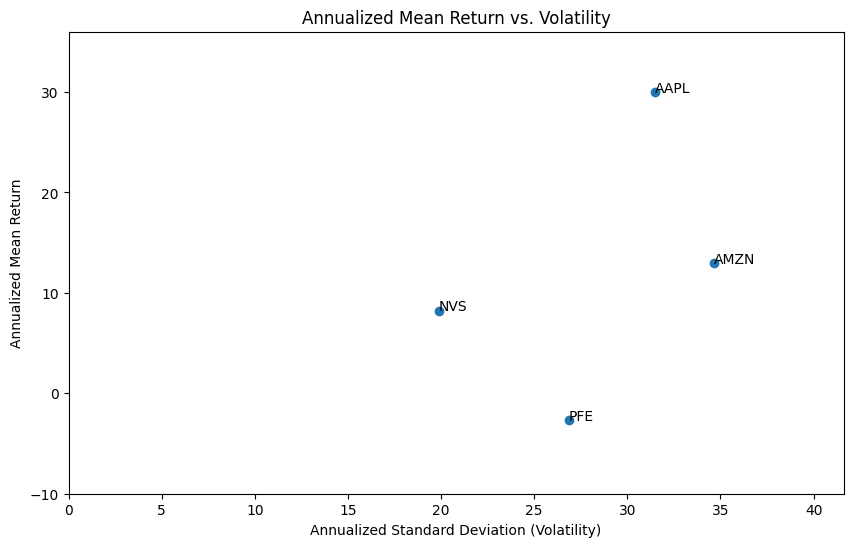

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(annualized_std, annualized_mean_return)

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker)

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')

plt.xlim(0, max(annualized_std) * 1.2)
plt.ylim(-10, max(annualized_mean_return) * 1.2)

plt.show()

In [10]:
df_log_returns.corr()

ticker,AAPL,AMZN,NVS,PFE
ticker,,,,
AAPL,1.000000,0.604045,0.385492,0.297716
AMZN,0.604045,1.000000,0.257495,0.180571
NVS,0.385492,0.257495,1.000000,0.431738
PFE,0.297716,0.180571,0.431738,1.000000


In [11]:
cov_matrix = df_log_returns.cov() * trading_days_per_year
cov_matrix

ticker,AAPL,AMZN,NVS,PFE
ticker,,,,
AAPL,990.040351,658.997161,241.066589,251.628652
AMZN,658.997161,1202.197928,177.440104,168.178020
NVS,241.066589,177.440104,394.994064,230.487882
PFE,251.628652,168.178020,230.487882,721.546345


In [12]:
portfolio_returns = []
portfolio_volatilities = []

In [13]:
weights = np.linspace(0, 1, 20)

for w in weights:
    weight_array = np.array([w, 1 - w])
    portfolio_return = np.dot(weight_array, [annualized_mean_return['AAPL'], annualized_mean_return['NVS']])
    portfolio_volatility = np.sqrt(np.dot(weight_array.T, np.dot(cov_matrix.loc[['AAPL', 'NVS'], ['AAPL', 'NVS']], weight_array)))
    portfolio_returns.append(portfolio_return)
    portfolio_volatilities.append(portfolio_volatility)

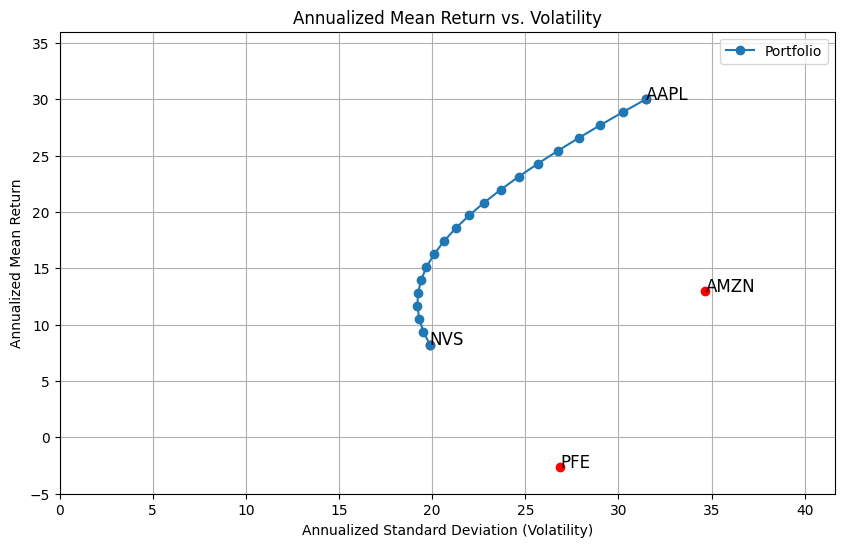

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(portfolio_volatilities, portfolio_returns, marker='o', label='Portfolio')

plt.scatter(annualized_std, annualized_mean_return, color='red')

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker, fontsize=12)

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')
plt.grid(True)

plt.xlim(0, max(annualized_std) * 1.2)
plt.ylim(-5, max(annualized_mean_return) * 1.2)

plt.legend()

plt.show()


In [20]:
# Gewichtungen definieren
num_portfolios = 500_000
num_assets = len(df_log_returns.columns)
results = np.zeros((3 + num_assets, num_portfolios))

for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    portfolio_return = np.dot(weights, annualized_mean_return)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    results[0, i] = portfolio_volatility
    results[1, i] = portfolio_return
    results[2, i] = sharpe_ratio
    results[3:, i] = weights

In [21]:
min_volatility_idx = np.argmin(results[0])
min_volatility = results[0, min_volatility_idx]
min_volatility_return = results[1, min_volatility_idx]
min_volatility_weights = results[3:, min_volatility_idx]

max_sharpe_idx = np.argmax(results[2])
max_sharpe_ratio = results[2, max_sharpe_idx]
max_sharpe_volatility = results[0, max_sharpe_idx]
max_sharpe_return = results[1, max_sharpe_idx]
max_sharpe_weights = results[3:, max_sharpe_idx]

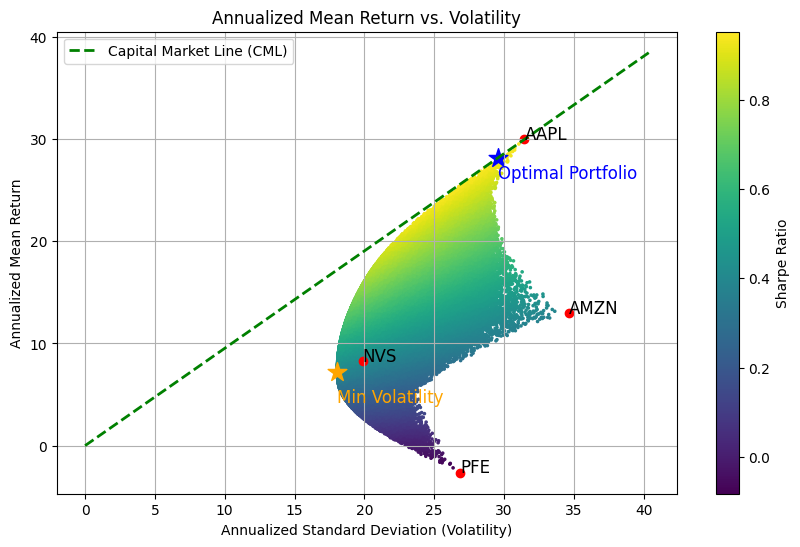

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', marker='.', s=10)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(annualized_std, annualized_mean_return, color='red')

for ticker in annualized_std.index:
    plt.text(annualized_std[ticker], annualized_mean_return[ticker], ticker, fontsize=12)

plt.scatter(max_sharpe_volatility, max_sharpe_return, color='blue', marker='*', s=200)
plt.text(max_sharpe_volatility, max_sharpe_return -2, 'Optimal Portfolio', fontsize=12, color='blue')


plt.scatter(min_volatility, min_volatility_return, color='orange', marker='*', s=200)
plt.text(min_volatility, min_volatility_return - 3, 'Min Volatility', fontsize=12, color='orange')

cml_x = np.linspace(0, max(results[0]) * 1.2, 100)
cml_y = risk_free_rate + max_sharpe_ratio * cml_x
plt.plot(cml_x, cml_y, color='green', linestyle='--', linewidth=2, label='Capital Market Line (CML)')

plt.xlabel('Annualized Standard Deviation (Volatility)')
plt.ylabel('Annualized Mean Return')
plt.title('Annualized Mean Return vs. Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
print(f"\nPortfolio mit der geringsten Volatilität:")
print(f"Volatilität: {min_volatility:.4f}")
print(f"Rendite: {min_volatility_return:.4f}")
print(f"Gewichtungen:")
for ticker, weight in zip(df_log_returns.columns, min_volatility_weights):
    print(f"{ticker}: {weight:.4f}")


Portfolio mit der geringsten Volatilität:
Volatilität: 18.0675
Rendite: 7.2225
Gewichtungen:
AAPL: 0.0329
AMZN: 0.1306
NVS: 0.6206
PFE: 0.2159


In [24]:
print(f"Optimal Portfolio (Highest Sharpe Ratio):")
print(f"Sharpe Ratio: {max_sharpe_ratio:.4f}")
print(f"Volatilität: {max_sharpe_volatility:.4f}")
print(f"Rendite: {max_sharpe_return:.4f}")
print(f"Gewichtungen:")
for ticker, weight in zip(df_log_returns.columns, max_sharpe_weights):
    print(f"{ticker}: {weight:.4f}")

Optimal Portfolio (Highest Sharpe Ratio):
Sharpe Ratio: 0.9524
Volatilität: 29.5643
Rendite: 28.1580
Gewichtungen:
AAPL: 0.9131
AMZN: 0.0100
NVS: 0.0769
PFE: 0.0000
